In [1]:
import os, glob, re, math
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore

# ----------------------
# Experiment time window
# ----------------------
BIN_MS   = 1          # ms per bin
ONSET_MS = 50          # stimulus onset time (ms) for the vertical line (visual aid)
WINDOW_MS = 450       # analysis window length (ms) for time slicing

# Derived (bin indices)
t_start = None # int(ONSET_MS / BIN_MS)
t_end   = None # t_start + int(WINDOW_MS / BIN_MS)

# ----------------------
# Image slice (global indices)
# ----------------------
GLOBAL_IMG_START = 1000
GLOBAL_IMG_END   = 1072   # end-exclusive; 1000..1071 are used by default

# The example folder contains files MFOB000..MFOB072.bmp corresponding to the above global span.
# Local index mapping assumes: local_idx = global_idx - GLOBAL_IMG_START

# ----------------------
# Clustering config
# ----------------------
RANDOM_STATE = 0
N_INIT = 10
K_RANGE = list(range(2, 9))  # candidate K

# How many example images to show per cluster
EXAMPLES_PER_CLUSTER = 30

DATA_DIR = '../../datasets/NNN/unit_data_full.pkl'
IMAGE_DIR = "../../datasets/NNN/NSD1000_LOC"
IMAGE_PATTERN = "MFOB{idx:03d}.bmp"  # local 000..072 files

In [2]:
# 72 localizer images; files are 1-indexed (001..072), data slice is 0-indexed
LOCALIZER_LEN = 72

def find_local_image_path(local_idx, image_dir=IMAGE_DIR, pattern=IMAGE_PATTERN):
    """
    Return full path to local image, using 0-based local_idx.
    Example: local_idx=0 -> MFOB001.bmp  (files are 1-indexed).
    """
    # Optional bounds check if you're strictly in the localizer set
    if not (0 <= int(local_idx) < LOCALIZER_LEN):
        # keep this as a warning rather than raising if you sometimes go beyond the localizer set
        pass

    file_idx = int(local_idx) + 1  # convert 0-based -> 1-based for BMP filenames
    fname = pattern.format(idx=file_idx)
    path = os.path.join(image_dir, fname)
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image not found: {path}")
    return path


def get_roi_last_letter(roi_label):
    if isinstance(roi_label, str) and len(roi_label) > 0:
        tail = roi_label[-1]
        if tail in {'B','O','F'}:
            return tail
    return 'Unknown'

def compute_image_time_traces_for_roi(dat_roi, img_start, img_end, t_start=None, t_end=None):
    """
    Build per-image time traces by averaging across units (rows) in dat_roi.
    Assumes each row['img_psth'] has shape (time, images).

    Returns
    -------
    X_img : np.ndarray, shape (n_images, T)
        Mean timecourse for each image across units in ROI.
    global_img_indices : list[int]
        The global image indices corresponding to rows of X_img.
    valid_units : int
        Number of units successfully included.
    """
    if len(dat_roi) == 0:
        raise ValueError("dat_roi has no rows.")

    # Infer time length from first valid row
    T_total = None
    for _, row in dat_roi.iterrows():
        A = np.asarray(row.get('img_psth', None))
        if A is None or A.ndim != 2:
            continue
        T_total = A.shape[0]
        break
    if T_total is None:
        raise ValueError("Could not infer time length; no valid img_psth arrays found.")

    # Time slice defaults
    if t_start is None: t_start = 0
    if t_end   is None: t_end   = T_total
    if t_end <= t_start:
        raise ValueError(f"t_end must be > t_start (got {t_start}, {t_end}).")

    n_images = int(img_end - img_start)
    T = int(t_end - t_start)

    accum = np.zeros((n_images, T), dtype=float)
    count = 0

    for i, row in dat_roi.iterrows():
        A = np.asarray(row.get('img_psth', None))
        if A is None or A.ndim != 2:
            # skip invalid
            continue
        # time slice then image slice
        B = A[t_start:t_end, img_start:img_end]  # (T, n_images)
        if B.shape[1] != n_images:
            # inconsistent image dimension; skip this unit
            continue
        accum += B.T  # (n_images, T)
        count += 1

    if count == 0:
        raise ValueError("No valid units in ROI or all img_psth incompatible.")

    X_img = accum / float(count)
    global_img_indices = list(range(img_start, img_end))
    return X_img, global_img_indices, count

def choose_k_and_cluster(X, k_range, random_state=0, n_init=10):
    """Return labels, best_k, inertias dict, silhouette list."""
    n_samples = X.shape[0]
    valid_ks = [k for k in k_range if 1 < k <= n_samples]
    inertias = {}
    sils = []
    labels_by_k = {}

    if len(valid_ks) == 0 or n_samples < 2:
        # degenerate: one cluster
        return np.zeros(n_samples, dtype=int), 1, {1: 0.0}, [(1, np.nan)]

    for k in valid_ks:
        km = KMeans(n_clusters=k, random_state=random_state, n_init=n_init)
        lab = km.fit_predict(X)
        inertias[k] = km.inertia_
        if len(np.unique(lab)) > 1:
            sil = silhouette_score(X, lab)
        else:
            sil = np.nan
        sils.append((k, sil))
        labels_by_k[k] = lab

    # choose max silhouette (fallback to smallest valid K if all NaN)
    finite = [(k, s) for (k, s) in sils if not (s is None or (isinstance(s, float) and math.isnan(s)))]
    if len(finite) == 0:
        best_k = valid_ks[0]
    else:
        best_k = max(finite, key=lambda kv: kv[1])[0]

    labels = labels_by_k[best_k]
    return labels, best_k, inertias, sils

def plot_all_clusters_one_figure(
    X_img_z, labels, global_img_indices,
    image_dir=IMAGE_DIR, image_pattern=IMAGE_PATTERN,
    title_prefix="", examples_per_cluster=6, onset_ms=None, bin_ms=1,
    global_start=GLOBAL_IMG_START
):
    """
    One figure per ROI:
      • Top: all cluster mean traces on the same axes (distinct colors).
      • Bottom: small example images, arranged in rows (one row per cluster),
                with an outline color matching the cluster trace.

    X_img_z: (n_images, T) per-image z-scored timecourses
    labels:  (n_images,) cluster labels
    global_img_indices: list[int] mapping row -> global image index (e.g., 1000..1071)
    """
    import math, os
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    clusters = sorted(np.unique(labels))
    t = np.arange(X_img_z.shape[1]) * bin_ms

    # Mean traces + counts per cluster
    means = {}
    counts = {}
    for i, c in enumerate(clusters):
        idxs = np.where(labels == c)[0]
        means[c] = X_img_z[idxs].mean(axis=0)
        counts[c] = len(idxs)

    # Consistent colors for traces and image borders
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    color_for = {c: default_colors[i % len(default_colors)] for i, c in enumerate(clusters)}

    # Grid: top row = traces; then one row per cluster for thumbnails
    nrows_img = len(clusters)
    ncols_img = max(1, int(examples_per_cluster))

    # Make images small by using modest height for the image rows
    fig_height = 3.0 + 1.0 * nrows_img + 0.4 * nrows_img
    fig = plt.figure(figsize=(12, fig_height))
    gs = fig.add_gridspec(
        nrows=1 + nrows_img, ncols=ncols_img,
        height_ratios=[2.2] + [1.0] * nrows_img,
        hspace=0.5, wspace=0.05
    )

    # Top: overlaid cluster means
    ax_top = fig.add_subplot(gs[0, :])
    for c in clusters:
        ax_top.plot(t, means[c], lw=2, color=color_for[c], label=f"Cluster {c} (n={counts[c]})")
    if onset_ms is not None:
        ax_top.axvline(onset_ms, ls="--", lw=1, color="k", alpha=0.6)
    ax_top.set_title(f"{title_prefix} — all clusters")
    ax_top.set_xlabel("Time (ms)")
    ax_top.set_ylabel("Z-scored response")
    ax_top.legend(frameon=False, ncol=min(len(clusters), 4), fontsize=9)

    # Bottom: rows of small images, one row per cluster
    for row_i, c in enumerate(clusters, start=1):
        idxs = np.where(labels == c)[0]
        # choose up to ncols_img examples
        take = idxs[:ncols_img]
        for col_j in range(ncols_img):
            ax_im = fig.add_subplot(gs[row_i, col_j])
            if col_j < len(take):
                ex_idx = take[col_j]
                global_idx = global_img_indices[ex_idx]
                local_idx = int(global_idx - global_start)           # 0..71 within localizer
                file_idx  = local_idx + 1                            # 1..72 for BMP filenames
                try:
                    path = os.path.join(image_dir, image_pattern.format(idx=file_idx))
                    im = Image.open(path).convert("RGB")
                    ax_im.imshow(im)
                except Exception:
                    ax_im.text(0.5, 0.5, f"missing\n{file_idx:03d}", ha="center", va="center", fontsize=8)
            ax_im.axis("off")
            # Outline matches cluster color
            for spine in ax_im.spines.values():
                spine.set_edgecolor(color_for[c])
                spine.set_linewidth(2)

    plt.tight_layout()
    plt.show()


In [3]:
dat = pd.read_pickle(DATA_DIR)

Found z7 F-ROIs: ['AF3_18_F', 'AMC3_28_F', 'MF1_7_F', 'MF1_8_F', 'MF1_9_F', 'Unknown_19_F', 'Unknown_5_F']
ROI AF3_18_F: n_images=72, n_units=608, best_k=3


/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_81461/1902575070.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


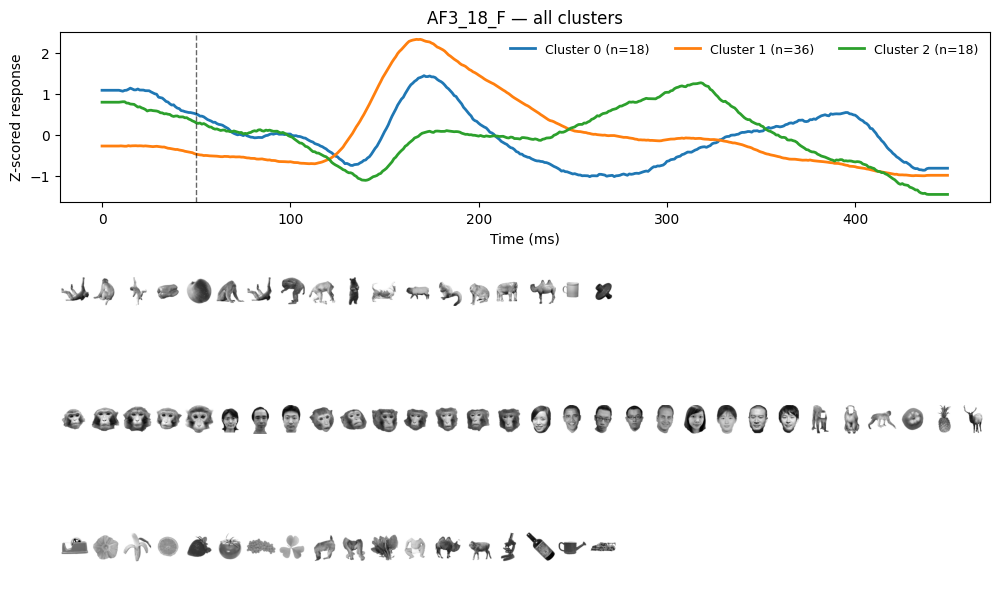

ROI AMC3_28_F: n_images=72, n_units=448, best_k=2


/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_81461/1902575070.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


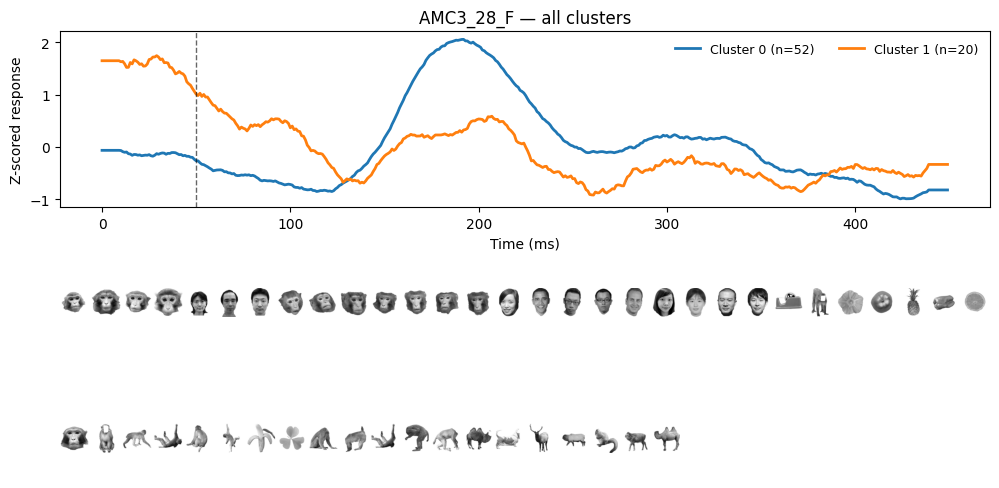

ROI MF1_7_F: n_images=72, n_units=587, best_k=2


/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_81461/1902575070.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


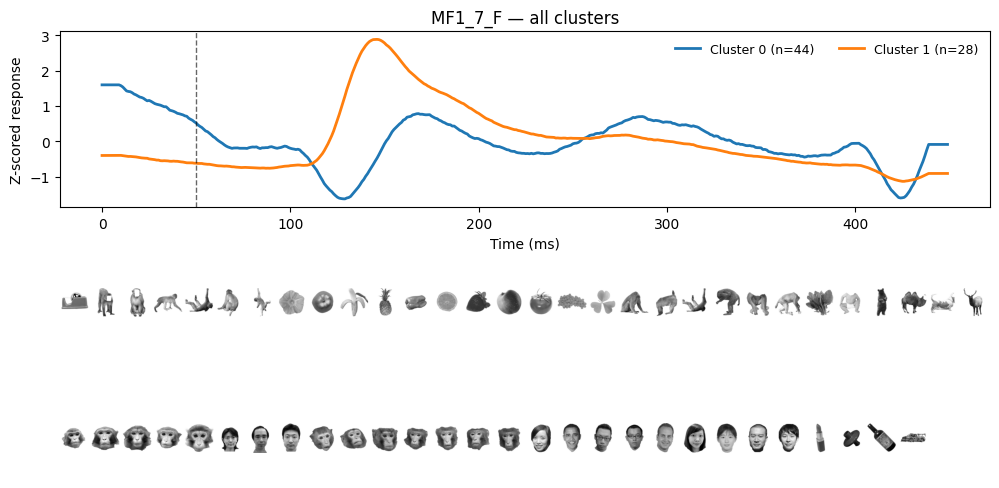

ROI MF1_8_F: n_images=72, n_units=1871, best_k=2


/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_81461/1902575070.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


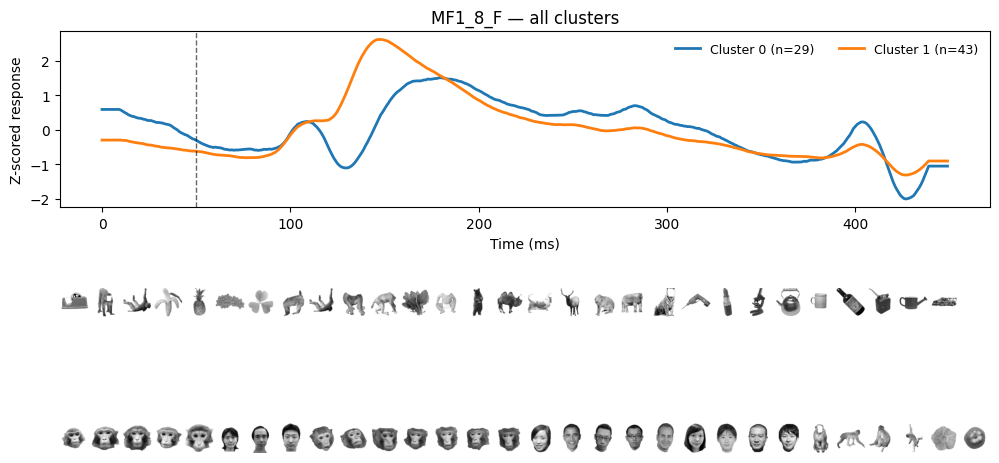

ROI MF1_9_F: n_images=72, n_units=474, best_k=2


/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_81461/1902575070.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


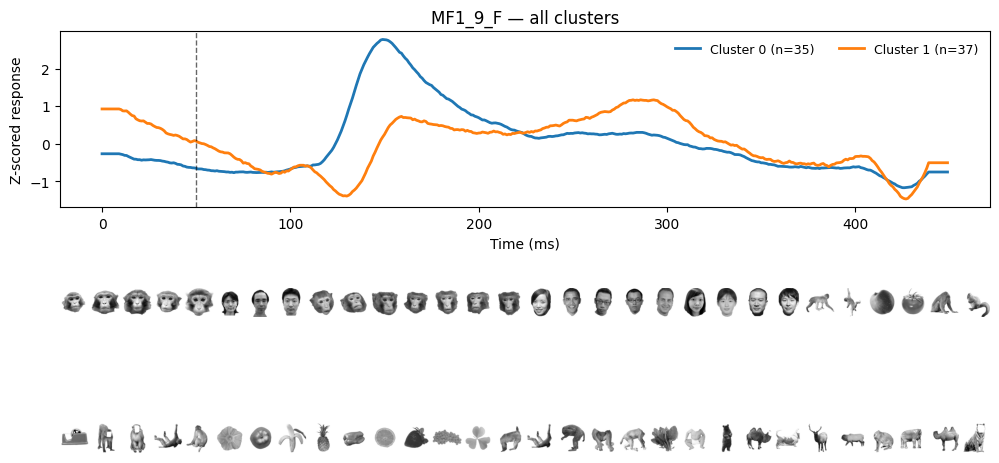

ROI Unknown_19_F: n_images=72, n_units=829, best_k=3


/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_81461/1902575070.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


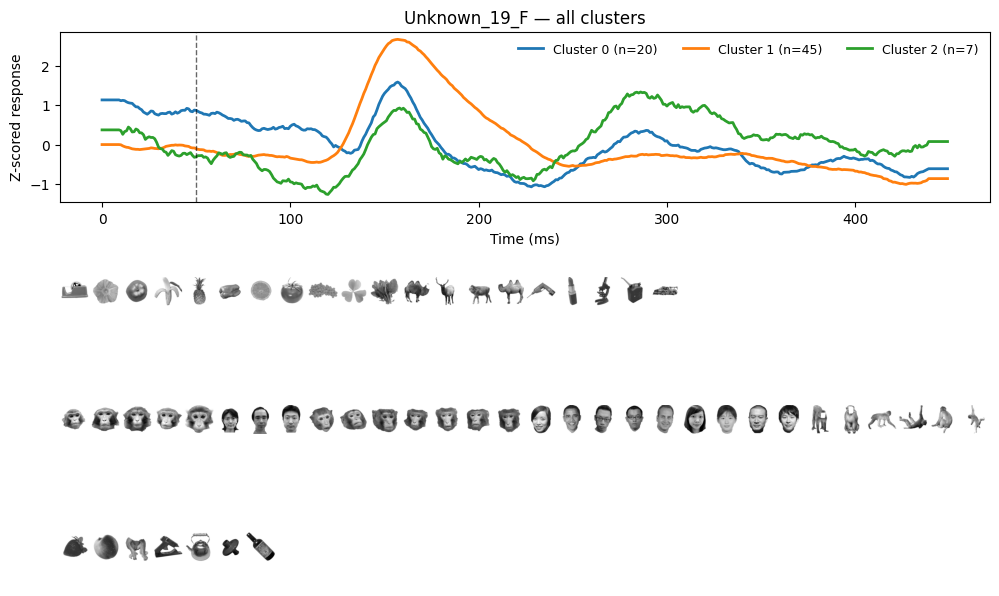

ROI Unknown_5_F: n_images=72, n_units=316, best_k=2


/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_81461/1902575070.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


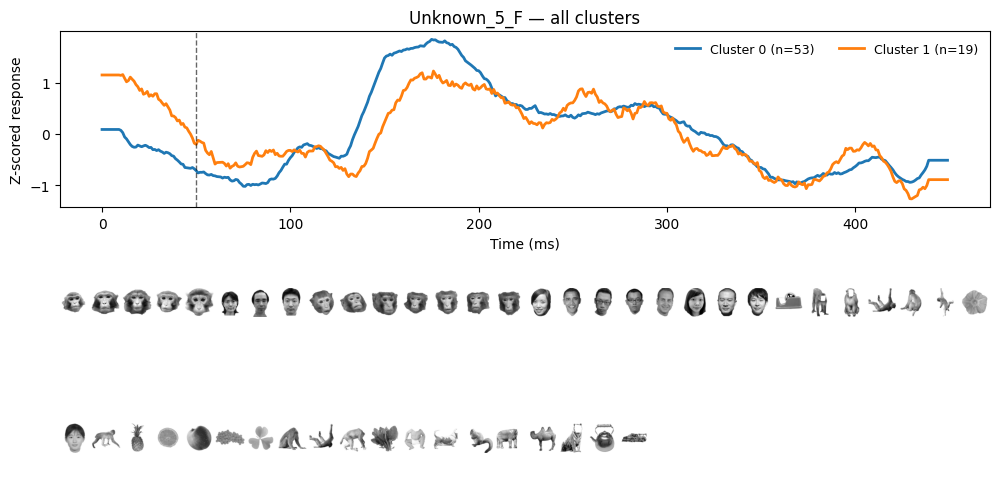

In [4]:
# Filter to valid rows (with some PSTH) and add convenience columns
dat_valid = dat.copy()
dat_valid['roi'] = dat_valid['roi'].fillna('Unknown')
dat_valid['sel'] = dat_valid['roi'].map(get_roi_last_letter)

# Choose ROIs ending in 'F'
ROI_SEL = 'F'
f_rois = sorted(dat_valid.loc[dat_valid['sel'] == ROI_SEL, 'roi'].unique())
print(f"Found z{len(f_rois)} F-ROIs: {f_rois}")

for roi_name in f_rois:
    dat_roi = dat_valid.loc[dat_valid['roi'] == roi_name]
    try:
        X_img, global_img_indices, n_units = compute_image_time_traces_for_roi(
            dat_roi, img_start=GLOBAL_IMG_START, img_end=GLOBAL_IMG_END,
            t_start=t_start, t_end=t_end
        )
    except Exception as e:
        print(f"Skipping ROI {roi_name}: {e}")
        continue

    # Z-score per-image across time (shape-based clustering)
    X_img_z = zscore(X_img, axis=1)
    X_img_z = np.nan_to_num(X_img_z, nan=0.0, posinf=0.0, neginf=0.0)

    # Cluster
    labels, best_k, inertias, sils = choose_k_and_cluster(
        X_img_z, K_RANGE, random_state=RANDOM_STATE, n_init=N_INIT
    )

    print(f"ROI {roi_name}: n_images={X_img.shape[0]}, n_units={n_units}, best_k={best_k}")

    plot_all_clusters_one_figure(
        X_img_z, labels, global_img_indices,
        image_dir=IMAGE_DIR, image_pattern=IMAGE_PATTERN,
        title_prefix=f"{roi_name}", examples_per_cluster=EXAMPLES_PER_CLUSTER,
        onset_ms=ONSET_MS, bin_ms=BIN_MS, global_start=GLOBAL_IMG_START
    )

ROI O: n_images=72, n_units=10817, best_k=2


/var/folders/nz/k0v468mj4w5_mx5nsmsgbwwc0000gq/T/ipykernel_81461/1902575070.py:206: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


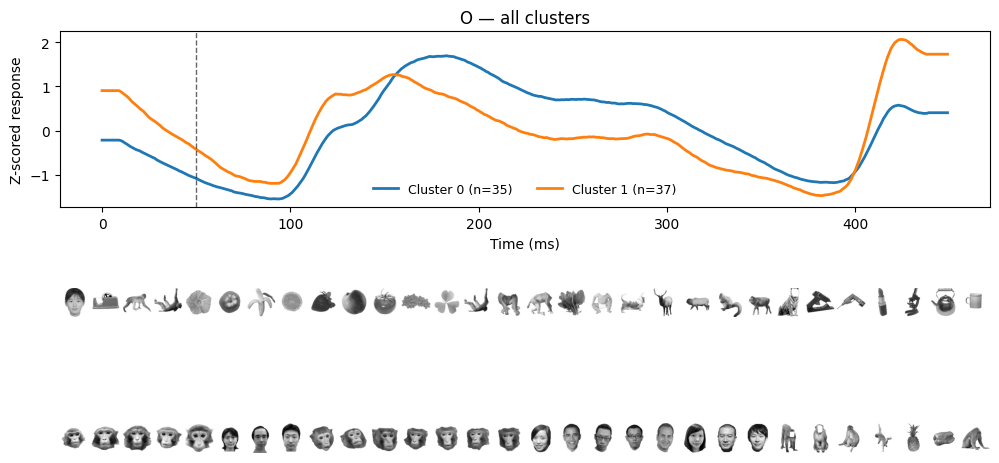

In [9]:
# Filter to valid rows (with some PSTH) and add convenience columns
dat_valid = dat.copy()
dat_valid['roi'] = dat_valid['roi'].fillna('Unknown')
dat_valid['sel'] = dat_valid['roi'].map(get_roi_last_letter)

ROI_SEL = 'O'
dat_roi = dat_valid.loc[dat_valid['sel'] == ROI_SEL]

X_img, global_img_indices, n_units = compute_image_time_traces_for_roi(
    dat_roi, img_start=GLOBAL_IMG_START, img_end=GLOBAL_IMG_END,
    t_start=t_start, t_end=t_end
)


# Z-score per-image across time (shape-based clustering)
X_img_z = zscore(X_img, axis=1)
X_img_z = np.nan_to_num(X_img_z, nan=0.0, posinf=0.0, neginf=0.0)

# Cluster
labels, best_k, inertias, sils = choose_k_and_cluster(
    X_img_z, K_RANGE, random_state=RANDOM_STATE, n_init=N_INIT
)

print(f"ROI {ROI_SEL}: n_images={X_img.shape[0]}, n_units={n_units}, best_k={best_k}")

plot_all_clusters_one_figure(
    X_img_z, labels, global_img_indices,
    image_dir=IMAGE_DIR, image_pattern=IMAGE_PATTERN,
    title_prefix=f"{ROI_SEL}", examples_per_cluster=EXAMPLES_PER_CLUSTER,
    onset_ms=ONSET_MS, bin_ms=BIN_MS, global_start=GLOBAL_IMG_START
)